## The goal of this Notebook is to analyze job posting data from LinkedIn, and determine whether or not a job posting is:

- remote
- hybrid
- on-site

In [4]:
import tensorflow as tf

### Jobs Data

In [5]:
import pandas as pd

try:
    df = pd.read_csv('linkedin_kaggle_job_postings.csv', on_bad_lines='skip')
except Exception as e:
    print(e)

### Cleaning the text

In [6]:
import pandas as pd
import tensorflow as tf
import re

try:
    df = pd.read_csv('linkedin_kaggle_job_postings.csv', on_bad_lines='skip')
except Exception as e:
    print(e)

def clean_text(text):
    # Ensure the input is a string
    text = str(text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Convert to lower case
    text = text.lower()
    return text

# Apply the updated cleaning function to your description column
df['description_cleaned'] = df['description'].apply(clean_text)

### I need to vectorize the data to turn it into something a 🤖 can read, so that's what I'll be doing here

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the cleaned job descriptions
X = tfidf_vectorizer.fit_transform(df['description_cleaned']).toarray()

# Check the shape of the resulting matrix
print(X.shape)

(33246, 5000)


### Splitting the data into training and test sets

In [8]:
from sklearn.preprocessing import LabelEncoder

# Instantiate the encoder
label_encoder = LabelEncoder()

# Assuming 'formatted_work_type' is the column you're using to indicate job type
# Ensure this column exists in your DataFrame and replace 'formatted_work_type' with the correct column name if different
if 'formatted_work_type' in df.columns:
    df['work_type_encoded'] = label_encoder.fit_transform(df['formatted_work_type'])
else:
    print("Column 'formatted_work_type' does not exist. Check the correct column name.")

In [9]:
from sklearn.model_selection import train_test_split

# Now that 'work_type_encoded' exists, you can use it as your target variable
X = df['description_cleaned']  # or the vectorized form, depending on your previous steps
y = df['work_type_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 26596 samples
Test set size: 6650 samples


## Training the model

Okay, now let's train the model

In [10]:
# Assuming 'description_cleaned' is your text column
X = tfidf_vectorizer.fit_transform(df['description_cleaned']).toarray()

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X, df['work_type_encoded'], test_size=0.2, random_state=42)

In [11]:
X_train.dtype, X_test.dtype

(dtype('float64'), dtype('float64'))

In [12]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [13]:
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# Fit the model
model_1.fit(X_train, y_train)

832/832 [==============================] - 5s 3ms/step - loss: 0.5149 - accuracy: 0.8468


In [15]:
# Evalaute the model
model_1.evaluate(X_test, y_test)

208/208 [==============================] - 1s 2ms/step - loss: 0.3835 - accuracy: 0.8794


[0.3834722638130188, 0.8793985247612]

### Okay let's visualize this first model
Here's the model architecture

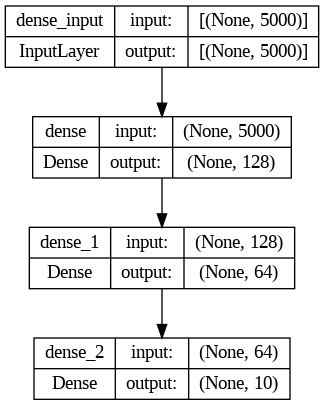

In [16]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

In [17]:
history = model_1.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=10,
                      batch_size=32)

Epoch 1/10
832/832 [==============================] - 4s 5ms/step - loss: 0.3012 - accuracy: 0.8982 - val_loss: 0.3519 - val_accuracy: 0.8832
Epoch 2/10
832/832 [==============================] - 3s 4ms/step - loss: 0.2050 - accuracy: 0.9311 - val_loss: 0.3729 - val_accuracy: 0.8830
Epoch 3/10
832/832 [==============================] - 3s 4ms/step - loss: 0.1254 - accuracy: 0.9583 - val_loss: 0.4460 - val_accuracy: 0.8823
Epoch 4/10
832/832 [==============================] - 3s 3ms/step - loss: 0.0736 - accuracy: 0.9764 - val_loss: 0.5109 - val_accuracy: 0.8847
Epoch 5/10
832/832 [==============================] - 4s 4ms/step - loss: 0.0501 - accuracy: 0.9846 - val_loss: 0.5619 - val_accuracy: 0.8788
Epoch 6/10
832/832 [==============================] - 3s 4ms/step - loss: 0.0409 - accuracy: 0.9866 - val_loss: 0.5842 - val_accuracy: 0.8786
Epoch 7/10
832/832 [==============================] - 3s 3ms/step - loss: 0.0358 - accuracy: 0.9880 - val_loss: 0.6239 - val_accuracy: 0.8749
Epoch 

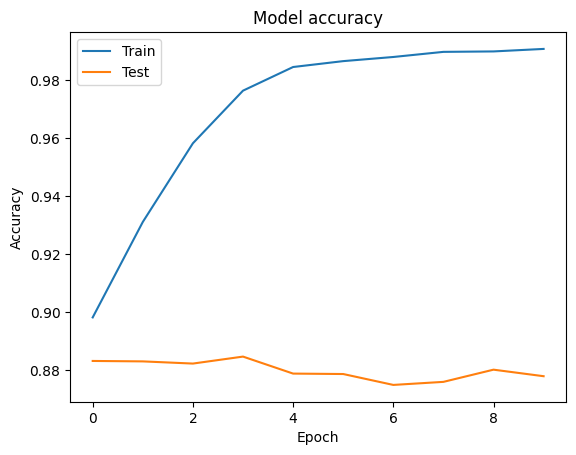

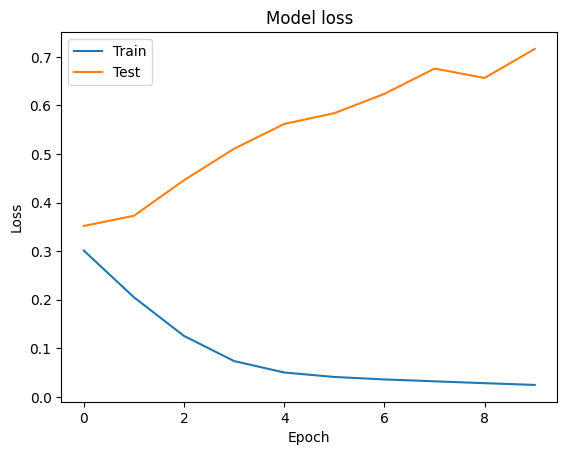

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Looks like my first model is overfitting.

So let's build a second model that will hopefully work better!

For this one we're going to build a sequential neural network.

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model_2 = Sequential([
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
# Train the model

from tensorflow.keras.callbacks import EarlyStopping

# Callback for early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model_2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
665/665 [==============================] - 5s 4ms/step - loss: 0.5856 - accuracy: 0.8359 - val_loss: 0.4021 - val_accuracy: 0.8671
Epoch 2/50
665/665 [==============================] - 2s 4ms/step - loss: 0.3591 - accuracy: 0.8841 - val_loss: 0.3922 - val_accuracy: 0.8667
Epoch 3/50
665/665 [==============================] - 2s 4ms/step - loss: 0.2684 - accuracy: 0.9116 - val_loss: 0.3959 - val_accuracy: 0.8748
Epoch 4/50
665/665 [==============================] - 3s 5ms/step - loss: 0.1997 - accuracy: 0.9334 - val_loss: 0.4843 - val_accuracy: 0.8720
Epoch 5/50
665/665 [==============================] - 3s 5ms/step - loss: 0.1405 - accuracy: 0.9518 - val_loss: 0.5163 - val_accuracy: 0.8786


In [21]:
# Evaluate the model
test_loss, test_acc = model_2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

208/208 [==============================] - 1s 2ms/step - loss: 0.3831 - accuracy: 0.8722
Test accuracy: 0.8722


### Let's visualize this second model

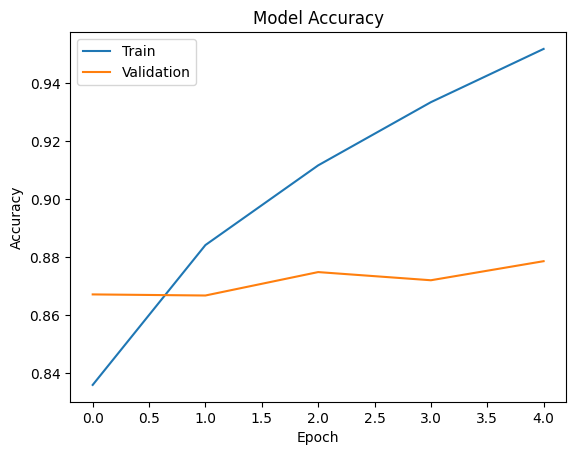

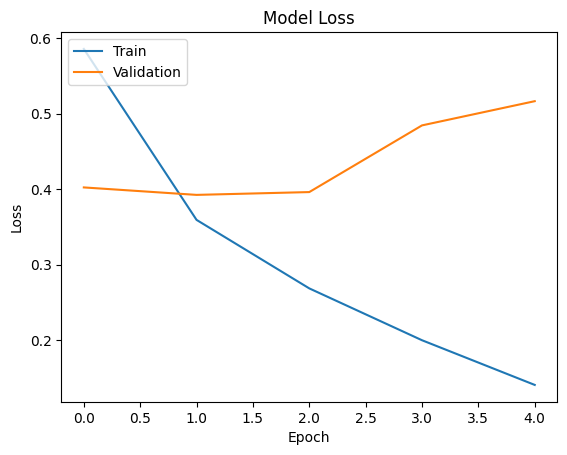

In [22]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Looking at real data

I want to look at some actual job postings, and see whether or not my model predicts whether it is remote / hybrid / on-site correctly.

So let's do that next.

In [23]:
def preprocess_text(text, vectorizer):
    # Clean the text
    cleaned_text = clean_text(text)  # Replace with your actual cleaning function

    # Convert the text to a numerical vector
    vectorized_text = vectorizer.transform([cleaned_text])

    return vectorized_text.toarray()  # Make sure it's in the same format as your training data


### I need a random job posting from my data

In [24]:
import pandas as pd

# Load the dataset
df = pd.read_csv('linkedin_kaggle_job_postings.csv')

# Select a random job posting from the DataFrame
random_job_posting = df.sample(1).iloc[0]

# Display the job posting
random_job_posting_description = random_job_posting['description']
print(random_job_posting_description)


We are looking for a Warehouse Maintenance Technician to join our team. The ideal candidate will be organized, detail-oriented, and have excellent problem-solving skills.
The Warehouse Maintenance Technician will be responsible for ensuring that the warehouse facility is maintained in a safe and orderly condition. This includes performing minor repairs, preventative maintenance, and general upkeep of the warehouse. Additionally, the Warehouse Maintenance Technician will be responsible for inspecting and testing equipment, troubleshooting issues, and recommending solutions.
Responsibilities:
Perform minor repairs, preventative maintenance, and general upkeep of warehouse.Inspect and test equipment regularly.Troubleshoot issues and recommend solutions.Maintain accurate records of all repairs and preventative maintenance.Ensure compliance with all safety regulations and policies.Assist with other warehouse duties when needed.
Qualifications:
High school diploma or GED required.1+ years of

In [25]:
# Need to vectorize the text
cleaned_job_posting = clean_text(random_job_posting_description)

# Assuming `tfidf_vectorizer` is your TfidfVectorizer instance
vectorized_job_posting = tfidf_vectorizer.transform([cleaned_job_posting])

In [26]:
# Convert the vectorized sparse matrix to a dense array
dense_vectorized_job_posting = vectorized_job_posting.toarray()

# Now let's predict the location of the job
prediction = model_2.predict(dense_vectorized_job_posting)

1/1 [==============================] - 0s 105ms/step


In [27]:
# Now let's predict the location of the job
import numpy as np
prediction = model_2.predict(dense_vectorized_job_posting)

# If your model outputs one-hot encoded predictions, convert to label
predicted_label = np.argmax(prediction, axis=1)

# Decode the predicted label (if you used label encoding)
# If you have the label encoder saved as 'label_encoder', you can reverse the encoding to get the original label
predicted_job_type = label_encoder.inverse_transform(predicted_label)[0]

print(f"The model predicts this job is: {predicted_job_type}")


1/1 [==============================] - 0s 19ms/step
The model predicts this job is: Full-time


## Alright, seems like I may have been using the wrong classifier to predict whether a job is remote or not. So I need to take that into consideration for my next model.

### For model_3, I'm going to use the following columns from the dataset:

- title
- description
- location
- remote_allowed

Then I need to:

- Preprocess each feature
- Combine those features into a single feature set
- Train the model on the combined feature set
- Evaluate the model

### Preprocessing the data

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Clean the text data
df['title_cleaned'] = df['title'].apply(clean_text)
df['description_cleaned'] = df['description'].apply(clean_text)

# Initialize TF-IDF Vectorizers
title_vectorizer = TfidfVectorizer(max_features=1000)
description_vectorizer = TfidfVectorizer(max_features=1000)

# Fit the vectorizers on the respective text data
title_tfidf = title_vectorizer.fit_transform(df['title_cleaned'])
description_tfidf = description_vectorizer.fit_transform(df['description_cleaned'])

### Handling the remote_allowed feature

In [29]:
df['remote_allowed'] = df['remote_allowed'].apply(lambda x: 1 if x == 'Yes' else 0)

### Handling the location feature

In [30]:
import pandas as pd

# Load the dataset
df = pd.read_csv('linkedin_kaggle_job_postings.csv')

# Check if 'location' is in the DataFrame after loading
if 'location' in df.columns:
    print("The 'location' column is present.")
else:
    print("The 'location' column is missing.")


The 'location' column is present.


In [31]:
# One-hot encode the 'location' column
if 'location' in df.columns:
    location_encoded = pd.get_dummies(df['location'], prefix='loc')
    print(location_encoded.head())


   loc_Abbeville, SC  loc_Aberdeen Proving Ground, MD  loc_Aberdeen, MD  \
0                  0                                0                 0   
1                  0                                0                 0   
2                  0                                0                 0   
3                  0                                0                 0   
4                  0                                0                 0   

   loc_Aberdeen, SD  loc_Aberdeen, WA  loc_Abilene, TX  loc_Abingdon, VA  \
0                 0                 0                0                 0   
1                 0                 0                0                 0   
2                 0                 0                0                 0   
3                 0                 0                0                 0   
4                 0                 0                0                 0   

   loc_Abo, MO  loc_Absecon, NJ  loc_Acampo, CA  ...  loc_Yuba City, CA  \
0            0   

### Combining all features

In [32]:
# Convert sparse vectors to dense
title_dense = title_tfidf.toarray()
description_dense = description_tfidf.toarray()

# Concatenate all features into a single numpy array
features = np.concatenate(
    [title_dense, description_dense,
    df['remote_allowed'].values.reshape(-1,1),
    location_encoded.values],
    axis=1
)

### Prepare the target variable

In [33]:
y = df['remote_allowed'].values

In [34]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

Hmm... well I wish that was true, but I don't think this is 100% accurate.

Let's investigate

### Having trouble with the remote_allowed column... let's build a different model that leaves that out.

We'll be using the following columns instead:

- title
- description
- location

In [35]:
# Replace NaN values in 'title' and 'description' with empty strings
df['title'] = df['title'].fillna('')
df['description'] = df['description'].fillna('')

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizing 'title'
title_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
title_tfidf = title_vectorizer.fit_transform(df['title'])

# Vectorizing 'description'
description_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
description_tfidf = description_vectorizer.fit_transform(df['description'])


In [37]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding 'location'
location_encoder = OneHotEncoder(sparse=False)
location_encoded = location_encoder.fit_transform(df[['location']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [38]:
import scipy.sparse as sp

# Assuming 'title_tfidf', 'description_tfidf' are sparse and 'location_encoded' is dense
features = sp.hstack((title_tfidf, description_tfidf, sp.csr_matrix(location_encoded)), format='csr')

In [39]:
# Manually creating a binary target variable
df['is_remote'] = df.apply(lambda row: 1 if 'remote' in row['description'].lower() else 0, axis=1)


In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, df['is_remote'], test_size=0.2, random_state=42)

In [41]:
from sklearn.ensemble import RandomForestClassifier

model_4 = RandomForestClassifier(random_state=42)
model_4.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [42]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model_4.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9187969924812031
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5632
           1       1.00      0.47      0.64      1018

    accuracy                           0.92      6650
   macro avg       0.96      0.74      0.80      6650
weighted avg       0.93      0.92      0.91      6650



Overview of these results:

- High Overall Accuracy: The model achieved an overall accuracy of approximately 91.9% in predicting whether jobs allow remote work, indicating strong performance in general classification tasks.

- Excellent Precision for Remote Jobs: The model demonstrated a precision of 100% for predicting remote jobs (class 1), meaning virtually all jobs it classified as remote were indeed remote.

- Varied Recall Performance: The recall was 100% for non-remote jobs (class 0), ensuring all non-remote jobs were identified. However, the recall for remote jobs (class 1) was lower at 47%, indicating the model missed over half of the actual remote opportunities.

- Imbalanced Class Representation: The disparity in performance metrics between the two classes suggests an impact of class imbalance, with the model being more conservative in predicting jobs as remote.

- Opportunity for Recall Improvement: The lower recall for remote jobs highlights an opportunity for improvement, suggesting a need for strategies that enhance the model's sensitivity to detecting remote jobs without sacrificing its high precision.

## Let's work on model_5

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizers
title_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
description_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the text data
title_tfidf = title_vectorizer.fit_transform(df_upsampled['title'])
description_tfidf = description_vectorizer.fit_transform(df_upsampled['description'])

In [47]:
from sklearn.preprocessing import OneHotEncoder

# Assuming 'location' is a categorical feature you want to include
onehot_encoder = OneHotEncoder()
location_encoded = onehot_encoder.fit_transform(df_upsampled[['location']])

In [48]:
from scipy.sparse import hstack

# Combine all features into a single sparse matrix
X = hstack((title_tfidf, description_tfidf, location_encoded))

In [50]:
from sklearn.utils import resample

# Separate the majority and minority classes
df_majority = df[df.is_remote==0]
df_minority = df[df.is_remote==1]

# Oversample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Now use df_upsampled to split your data again
X = hstack((title_tfidf, description_tfidf, location_encoded))
y = df_upsampled['is_remote']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
y = df_upsampled['is_remote'].values  # Ensure 'y' is correctly set to your target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Train the model on the balanced training set
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [53]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# More detailed performance analysis
print(classification_report(y_test, y_pred))

Accuracy: 0.9968
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5602
           1       1.00      0.99      1.00      5594

    accuracy                           1.00     11196
   macro avg       1.00      1.00      1.00     11196
weighted avg       1.00      1.00      1.00     11196



### This still seems extremely high, so not sure I trust this.

Let's look at some random rows of data and see what the predictions are

In [85]:
import numpy as np

# Randomly select a row
random_row = df.sample(n=1, random_state=np.random.randint(100))

# Print the title, description, and location for verification
print(f"Title: {random_row['title'].values[0]}")
print(f"Description: {random_row['description'].values[0]}")
print(f"Location: {random_row['location'].values[0]}\n")

Title: Service Desk Lead
Description: Overview

Our client is one of the nation’s top tier consulting firms and is featured in Fortune Magazine’s Top 10 list of the most admired companies in the world. They have a contract opportunity for a Service Desk Lead to perform O&M work on a Federal Project based in College Park, MD / Washington, DC. The work is primarily remote, but candidates must be local as onsite presence could be needed on occasion.

Per our Federal Government Contract, candidates must be U.S. Citizens and be able to pass the client’s background check.

Qualifications

 Bachelor’s degree in Computer Science or related field  4+ years of experience in IT Service Desk support, and 2 years in software development as a tester, business analyst, developer, or some other hands-on role  Proven track record of team management, including adequate training, delegation, and motivation  Strong analytical, problem-solving, drive customer communication during critical events and commun

In [88]:
# Vectorize 'title' and 'description' for the selected row
title_tfidf_sample = title_vectorizer.transform(random_row['title'].fillna(''))
description_tfidf_sample = description_vectorizer.transform(random_row['description'].fillna(''))

if 'location' in random_row.columns:
    location_encoded_sample = onehot_encoder.transform(random_row[['location']].fillna('unknown'))

# Combine all features into a single feature set for the selected row
X_sample = hstack((title_tfidf_sample, description_tfidf_sample, location_encoded_sample))

In [89]:
# Make a prediction
y_pred_sample = model.predict(X_sample)

# Output the prediction
prediction = 'Remote' if y_pred_sample[0] == 1 else 'Not Remote'
print(f"The model predicts this job is: {prediction}")

The model predicts this job is: Remote
